In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
%matplotlib inline

print('Dependecies installed!')

Dependecies installed!


In [37]:
# Creating the run_query function:
chinook = 'ChinookDatabase/DataSources/Chinook_Sqlite.sqlite'

def run_query(q):
    with sqlite3.connect(chinook) as conn:
        return pd.read_sql(q, conn)
    
def run_command(c):
    with sqlite3.connect(chinook) as conn:
        conn.isolation_level = None
        conn.execute(c)
    
def show_tables():
    q = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");
    '''
    return run_query(q)

print('Displaying all tables:')
show_tables()

Displaying all tables:


,name,type
0,Album,table
1,Artist,table
2,Customer,table
3,Employee,table
4,Genre,table
5,Invoice,table
6,InvoiceLine,table
7,MediaType,table
8,Playlist,table
9,PlaylistTrack,table


# Finding the most popular genre in the USA:

In [81]:
popular_genres_in_usa = '''
WITH selecting_tracks_from_USA AS (
    SELECT il.*
    FROM InvoiceLine il
    INNER JOIN Invoice i ON i.InvoiceId = il.InvoiceId
    INNER JOIN Customer c ON c.CustomerId = i.CustomerId
    WHERE c.Country = 'USA')
           
SELECT 
    g.Name genre,
    COUNT(usa.InvoiceLineId) tracks_sold,
    CAST(COUNT(usa.InvoiceLineId) AS Float) / (SELECT COUNT(*) FROM selecting_tracks_from_USA) percentage_sold
FROM selecting_tracks_from_USA usa
INNER JOIN Track t ON t.TrackId = usa.TrackId
INNER JOIN Genre g ON g.GenreId = t.GenreId
GROUP BY g.Name
ORDER BY tracks_sold DESC
LIMIT 15;
'''

print('Displaying the most popular genre in the USA:')
run_query(popular_genres_in_usa)

Displaying the most popular genre in the USA:


,genre,tracks_sold,percentage_sold
0,Rock,157,0.317814
1,Latin,91,0.184211
2,Metal,64,0.129555
3,Alternative & Punk,50,0.101215
4,Jazz,22,0.044534
5,Blues,15,0.030364
6,TV Shows,14,0.028340
7,R&B/Soul,12,0.024291
8,Classical,8,0.016194
9,Comedy,8,0.016194


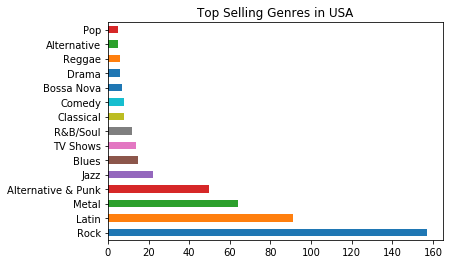

In [80]:
genre_sales_usa = run_query(popular_genres_in_usa)
genre_sales_usa.set_index("genre", inplace=True)

genre_sales_usa['tracks_sold'].plot.barh(title='Top Selling Genres in USA')
plt.ylabel('')
plt.show()

The 3 artists the will have the most success are Red Tone, Slim Jim Bites and Meteor and The Girls. However, combining the 3 artists together, they do not come close to the size of the market that Rock has.

# Evaluating employee performance:

In [100]:
employee_performance = '''
WITH only_sales_support_agents AS (
    SELECT *
    FROM Employee e
    WHERE e.Title = 'Sales Support Agent')
    
SELECT
    ossa.FirstName || ' ' || ossa.LastName employee_name,
    ossa.HireDate hiring_date,
    COUNT(c.SupportRepId) total_sales,
    SUM(i.total) total_value_of_sales
FROM only_sales_support_agents ossa
INNER JOIN Customer c ON c.SupportRepId = ossa.EmployeeId
INNER JOIN Invoice i ON i.CustomerId = c.CustomerId
GROUP BY employee_name;
'''
run_query(employee_performance)

,employee_name,hiring_date,total_sales,total_value_of_sales
0,Jane Peacock,2002-04-01 00:00:00,146,833.04
1,Margaret Park,2003-05-03 00:00:00,140,775.40
2,Steve Johnson,2003-10-17 00:00:00,126,720.16


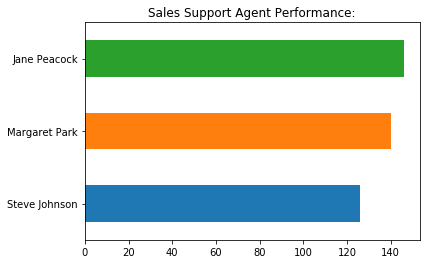

In [104]:
performance_of_employee = run_query(employee_performance)
performance_of_employee.set_index("employee_name", inplace=True)
performance_of_employee.sort_values('total_sales', inplace=True)

performance_of_employee['total_sales'].plot.barh(title='Sales Support Agent Performance:')
plt.ylabel('')
plt.show()

It looks that all 3 employees are performing similarly to each other; however, Steve Johnson who has the least amount of sales is also the last person to have been hired.